# RDFIA - M2 DAC - 2023/2024
# 3-a: Bayesian Linear Regression
# Done by : BOUTALEB Allaa & NEHLIL Samy

During this session, we will work with Bayesian Linear Regression models with varying basis functions (linear, polynomial and Gaussian). Datasets used are 1D toy regression samples ranging from linear datasets to more complex non-linear datasets such as increasing sinusoidal curves.

**Goal**: Take hand on simple Bayesian models, understand how it works, gain finer insights on predictive distribution.



In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

figpath = './figures/'

In [5]:
# Useful function: plot results
def plot_results(X_train, y_train, X_test, y_test, y_pred, std_pred,
                 xmin=-2, xmax=2, ymin=-2, ymax=1, stdmin=0.30, stdmax=0.45, save=False, save_path=None):
    """Given a dataset and predictions on test set, this function draw 2 subplots:
    - left plot compares train set, ground-truth (test set) and predictions
    - right plot represents the predictive variance over input range
    
    Args:
      X_train: (array) train inputs, sized [N,]
      y_train: (array) train labels, sized [N, ]
      X_test: (array) test inputs, sized [N,]
      y_test: (array) test labels, sized [N, ]
      y_pred: (array) mean prediction, sized [N, ]
      std_pred: (array) std prediction, sized [N, ]
      xmin: (float) min value for x-axis on left and right plot
      xmax: (float) max value for x-axis on left and right plot
      ymin: (float) min value for y-axis on left plot
      ymax: (float) max value for y-axis on left plot
      stdmin: (float) min value for y-axis on right plot
      stdmax: (float) max value for y-axis on right plot
      
    Returns:
      None
    """
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.xlim(xmin = xmin, xmax = xmax)
    plt.ylim(ymin = ymin, ymax = ymax)
    plt.plot(X_test, y_test, color='green', linewidth=2,
             label="Ground Truth")
    plt.plot(X_train, y_train, 'o', color='blue', label='Training points')
    plt.plot(X_test, y_pred, color='purple', label="BLR Poly")
    plt.fill_between(X_test, y_pred-std_pred, y_pred+std_pred, color='indianred', label='1 std. int.')
    plt.fill_between(X_test, y_pred-std_pred*2, y_pred-std_pred, color='lightcoral')
    plt.fill_between(X_test, y_pred+std_pred*1, y_pred+std_pred*2, color='lightcoral', label='2 std. int.')
    plt.fill_between(X_test, y_pred-std_pred*3, y_pred-std_pred*2, color='mistyrose')
    plt.fill_between(X_test, y_pred+std_pred*2, y_pred+std_pred*3, color='mistyrose', label='3 std. int.')
    plt.legend()

    plt.subplot(122)
    plt.title("Predictive variance along x-axis")
    plt.xlim(xmin = xmin, xmax = xmax)
    plt.ylim(ymin = stdmin, ymax = stdmax)
    plt.plot(X_test, std_pred**2, color='red', label="\u03C3² {}".format("Pred"))

    # Get training domain
    training_domain = []
    current_min = sorted(X_train)[0]
    for i, elem in enumerate(sorted(X_train)):
        if elem-sorted(X_train)[i-1]>1:
            training_domain.append([current_min,sorted(X_train)[i-1]])
            current_min = elem
    training_domain.append([current_min, sorted(X_train)[-1]])
    
    # Plot domain
    for j, (min_domain, max_domain) in enumerate(training_domain):
        plt.axvspan(min_domain, max_domain, alpha=0.5, color='gray', label="Training area" if j==0 else '')
    plt.axvline(X_train.mean(), linestyle='--', label="Training barycentre")   
    
    plt.legend()
    if save:
      plt.tight_layout()
      plt.savefig(save_path)
      
    plt.show()

## Part I: Linear Basis function model

We start with a linear dataset where we will analyze the behavior of linear basis functions in the framework of Bayesian Linear Regression.

In [6]:
# Generate linear toy dataset
def f_linear(x, noise_amount, sigma):
    y = -0.3 + 0.5*x
    noise = np.random.normal(0, sigma, len(x))
    return y + noise_amount*noise

# Create training and test points
sigma = 0.2
nbpts=25
dataset_linear = {}
dataset_linear['X_train'] = np.random.uniform(0, 2, nbpts)
dataset_linear['y_train'] = f_linear(dataset_linear['X_train'], noise_amount=1, sigma=sigma)
dataset_linear['X_test'] = np.linspace(-10,10, 10*nbpts)
dataset_linear['y_test'] = f_linear(dataset_linear['X_test'], noise_amount=0, sigma=sigma)

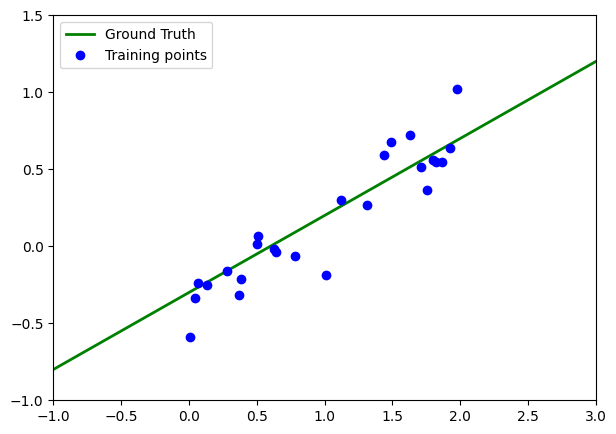

In [7]:
# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmax = 3, xmin =-1)
plt.ylim(ymax = 1.5, ymin = -1)
plt.plot(dataset_linear['X_test'], dataset_linear['y_test'], color='green', linewidth=2, label="Ground Truth")
plt.plot(dataset_linear['X_train'], dataset_linear['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.savefig(figpath+'linear_data.pdf')
plt.show()

In [8]:
# Hyperparameters
dataset_linear['ALPHA'] = 2.0 # Precision of the prior 
dataset_linear['BETA'] = 1/(2.0*sigma**2) # Noise precision

We will use the linear basis function:
    $\phi:x \rightarrow (1,x)$

Design matrix $\Phi$ defined on training set is:
$$ \Phi=
  \begin{bmatrix}
    1 & x_1 \\
    ... & ...\\
    1 & x_n
  \end{bmatrix}
$$

**Question 1.1: Code linear basis function**

In [9]:
def phi_linear(x):
    """ Linear Basis Functions 
    
    Args:
      x: (float) 1D input
      
    Returns:
      (array) linear features of x
    """
    return np.array([1, x])


**Question 1.2: Recall closed form of the posterior distribution in linear case. Then, code and visualize posterior sampling. What can you observe?**

C:\Users\maebo\AppData\Local\Temp\ipykernel_16772\2729586351.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  posterior[i, j] = np.exp(-0.5 * np.dot((w - mu_N.reshape(2, 1)).T, np.dot(np.linalg.inv(sigma_N), (w - mu_N.reshape(2, 1)))))


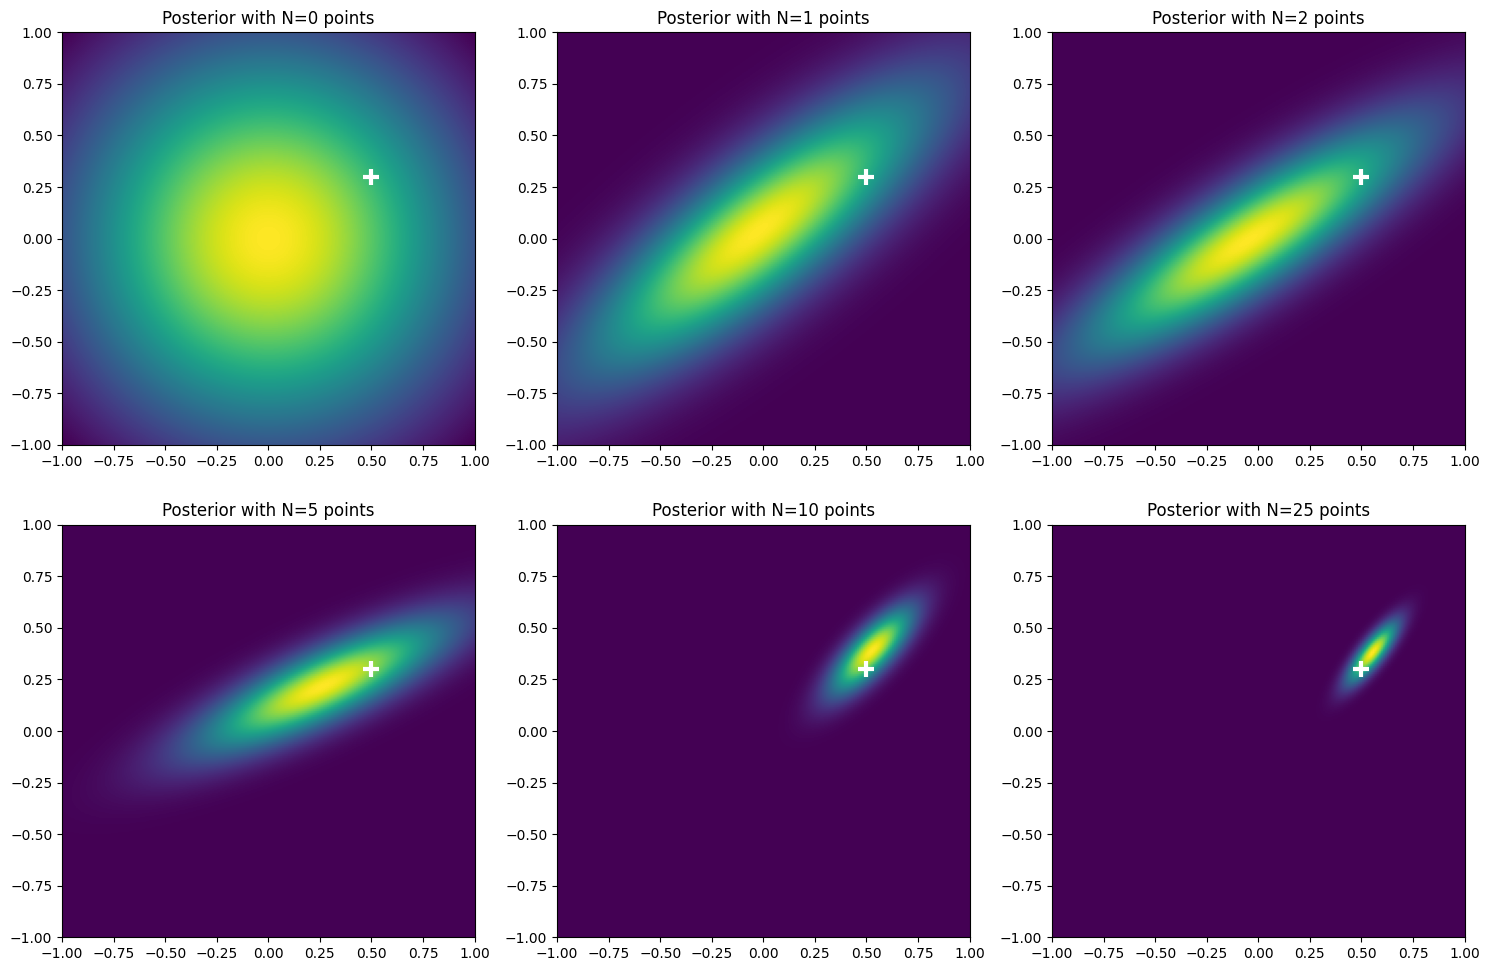

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Define the figure size for all subplots
plt.figure(figsize=(15, 10))

# Iterate over different numbers of data points
for count, n in enumerate([0, 1, 2, 5, 10, len(dataset_linear['X_train'])]):
    # Select the current subset of data points
    cur_data = dataset_linear['X_train'][:n]
    cur_lbl = dataset_linear['y_train'][:n]

    # Check if there are any data points to use
    if n > 0:
        # Construct the design matrix Phi using the linear basis function for the current data points
        Phi = np.array([phi_linear(x) for x in cur_data])
        # Compute the posterior mean (mu_N) and covariance (sigma_N)
        sigma_N = np.linalg.inv(dataset_linear['ALPHA'] * np.eye(2) + dataset_linear['BETA'] * np.dot(Phi.T, Phi))
        mu_N = dataset_linear['BETA'] * np.dot(sigma_N, np.dot(Phi.T, cur_lbl))
    else:
        # For zero data points, use the prior mean and covariance
        mu_N = np.zeros(2)  # Prior mean is a zero vector since we have no data
        sigma_N = np.linalg.inv(dataset_linear['ALPHA'] * np.eye(2))  # Prior covariance

    # Create a meshgrid for plotting the posterior distribution
    meshgrid = np.arange(-1, 1.01, 0.01)
    w = np.zeros((2, 1))
    posterior = np.zeros((meshgrid.shape[0], meshgrid.shape[0]))

    # Compute the posterior probability values for each point in the meshgrid
    for i in range(meshgrid.shape[0]):
        for j in range(meshgrid.shape[0]):
            w[0, 0] = meshgrid[i]
            w[1, 0] = meshgrid[j]
            posterior[i, j] = np.exp(-0.5 * np.dot((w - mu_N.reshape(2, 1)).T, np.dot(np.linalg.inv(sigma_N), (w - mu_N.reshape(2, 1)))))

    # Normalize the posterior probabilities so that they sum up to 1
    Z = 1.0 / (np.sqrt(2 * np.pi * np.linalg.det(sigma_N)))
    posterior[:, :] /= Z

    # Plot the posterior distribution for the current number of points
    plt.subplot(231 + count)
    plt.imshow(posterior, extent=[-1, 1, -1, 1])
    plt.plot(0.5, 0.3, '+', markeredgecolor='white', markeredgewidth=3, markersize=12)
    plt.title(f'Posterior with N={n} points')

# Adjust layout and save the figure to the specified path
plt.tight_layout()
plt.savefig(figpath + 'posterior_with_n_points.pdf')

# Display the plot
plt.show()


**Question 1.3: Recall and code closed form of the predictive distribution in linear case.**

In [11]:
def closed_form(func, X_train, y_train, alpha, beta, degree=None):
    """Define analytical solution to Bayesian Linear Regression, with respect to the basis function chosen, the
    training set (X_train, y_train) and the noise precision parameter beta and prior precision parameter alpha chosen.
    It should return a function outputting both mean and std of the predictive distribution at a point x*.

    Args:
      func: (function) the basis function used
      X_train: (array) train inputs, sized [N,]
      y_train: (array) train labels, sized [N, ]
      alpha: (float) prior precision parameter
      beta: (float) noise precision parameter
      degree: (int) optional, the degree of the polynomial if the polynomial basis function is used
      
    Returns:
      (function) prediction function, returning itself both mean and std
    """
    
    # Construct the design matrix Phi
    if degree is not None:
        Phi = np.array([func(x, degree) for x in X_train])
    else:
        Phi = np.array([func(x) for x in X_train])
    
    # Compute the posterior mean and covariance
    S_N = np.linalg.inv(alpha * np.eye(Phi.shape[1]) + beta * np.dot(Phi.T, Phi))
    m_N = beta * np.dot(np.dot(S_N, Phi.T), y_train)
    
    # The prediction function
    def f_model(x_star):
        if degree is not None:
            phi_x_star = np.array(func(x_star, degree))
        else:
            phi_x_star = np.array(func(x_star))
        
        mean = np.dot(m_N.T, phi_x_star)
        variance = 1.0 / beta + np.dot(phi_x_star.T, np.dot(S_N, phi_x_star))
        return mean, np.sqrt(variance)
    
    return f_model


In [12]:
f_pred = closed_form(phi_linear, dataset_linear['X_train'], dataset_linear['y_train'], 
                     dataset_linear['ALPHA'], dataset_linear['BETA'])

**Question 1.4: Based on previously defined ``f_pred()``, predict on the test dataset. Then visualize results using ``plot_results()`` defined at the beginning of the notebook.**

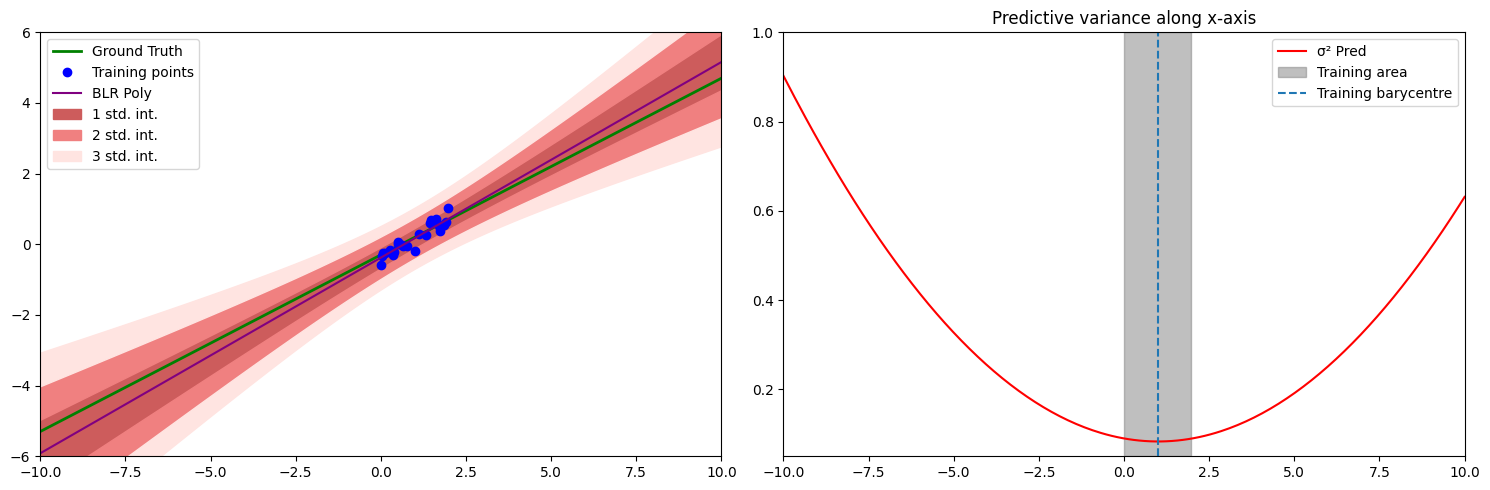

In [13]:
# Generate predictions for each point in X_test
predictions = [f_pred(x) for x in dataset_linear['X_test']]

# Extract means and standard deviations
means, stds = zip(*predictions)

# Plot the results
plot_results(dataset_linear['X_train'], dataset_linear['y_train'], 
             dataset_linear['X_test'], dataset_linear['y_test'], 
             np.array(means), np.array(stds), 
             xmin=-10, xmax=10, ymin=-6, ymax=6, stdmin=0.05, stdmax=1, save=True, save_path=figpath+'results_linear.pdf')


**Question 1.5: Analyse these results. Why predictive variance increases far from training distribution? Prove it analytically in the case where $\alpha=0$ and $\beta=1$.**

**<font color='red'>CHECK REPORT FOR ANSWERS</font>**

**Bonus Question: What happens when applying Bayesian Linear Regression on the following dataset?**

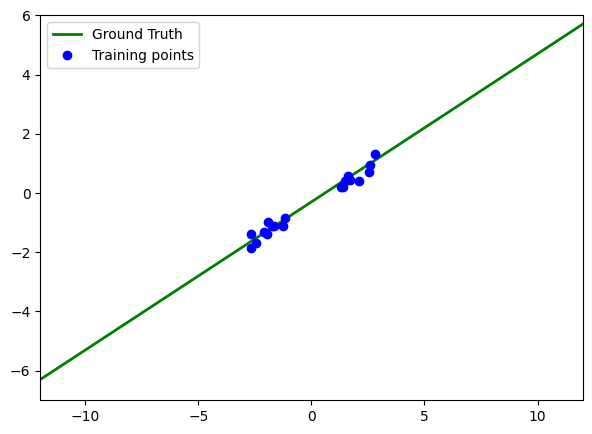

In [14]:
# Create training and test points
sigma = 0.2
dataset_hole = {}
dataset_hole['X_train'] = np.concatenate(([np.random.uniform(-3, -1, 10), np.random.uniform(1, 3, 10)]), axis=0)
dataset_hole['y_train'] = f_linear(dataset_hole['X_train'], noise_amount=1,sigma=sigma)
dataset_hole['X_test'] = np.linspace(-12,12, 100)
dataset_hole['y_test'] = f_linear(dataset_hole['X_test'], noise_amount=0,sigma=sigma)
dataset_hole['ALPHA'] = 2.0
dataset_hole['BETA'] = 1/(2.0*sigma**2)

# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmin =-12, xmax = 12)
plt.ylim(ymin = -7, ymax = 6)
plt.plot(dataset_hole['X_test'], dataset_hole['y_test'], color='green', linewidth=2, label="Ground Truth")
plt.plot(dataset_hole['X_train'], dataset_hole['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.savefig(figpath+'hole_data.pdf')
plt.show()

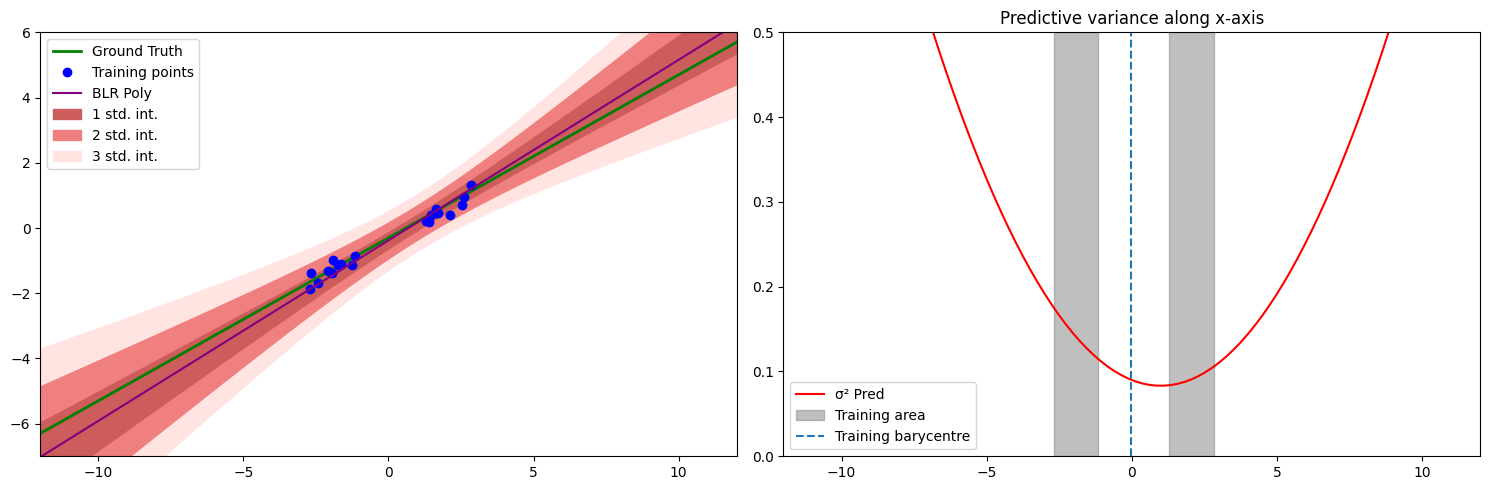

In [15]:
# Generate predictions for each point in X_test
predictions = [f_pred(x) for x in dataset_hole['X_test']]

# Extract means and standard deviations
means, stds = zip(*predictions)

# Plot the results
plot_results(dataset_hole['X_train'], dataset_hole['y_train'], 
             dataset_hole['X_test'], dataset_hole['y_test'], 
             np.array(means), np.array(stds), 
             xmin=-12, xmax=12, ymin=-7, ymax=6, stdmin=0.0, stdmax=0.5, save=True, save_path=figpath+'results_hole.pdf')

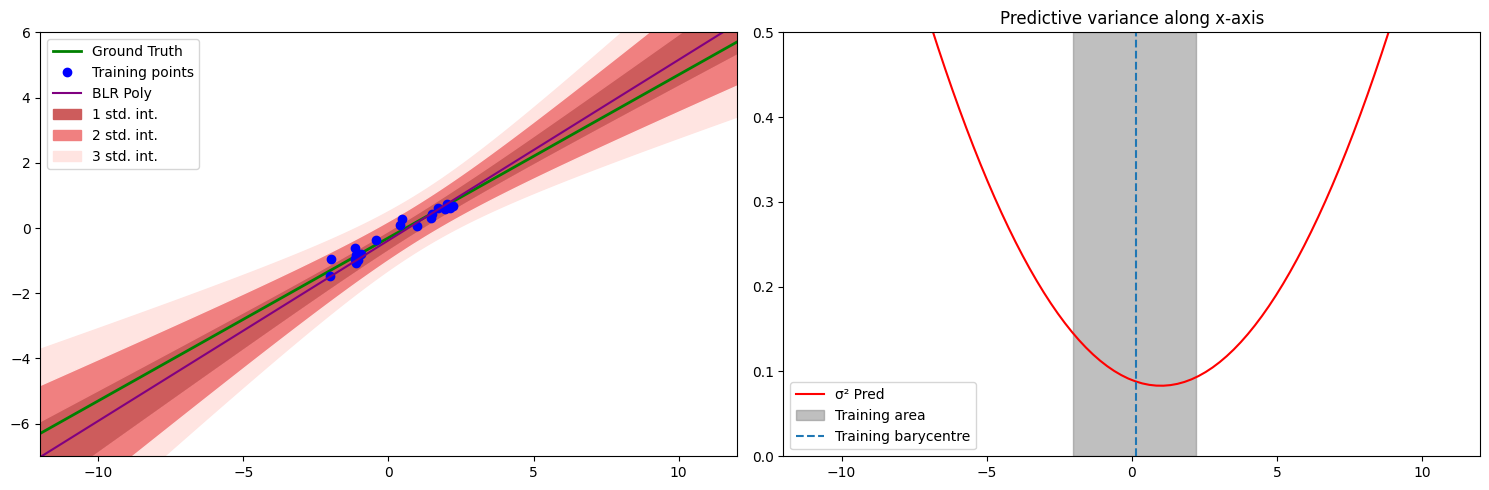

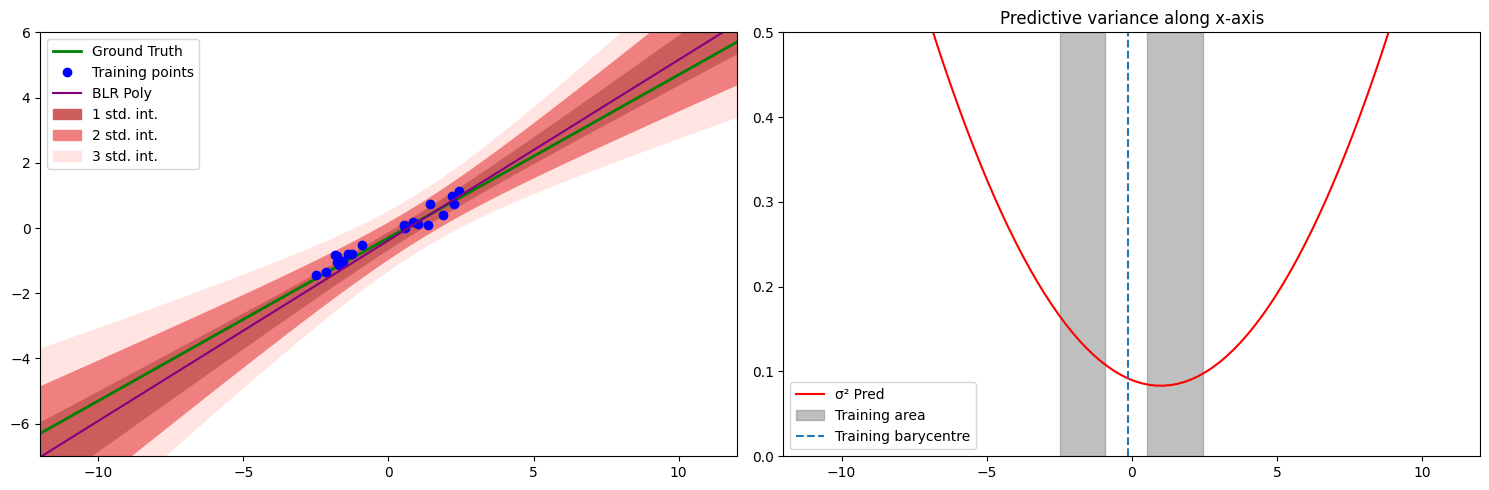

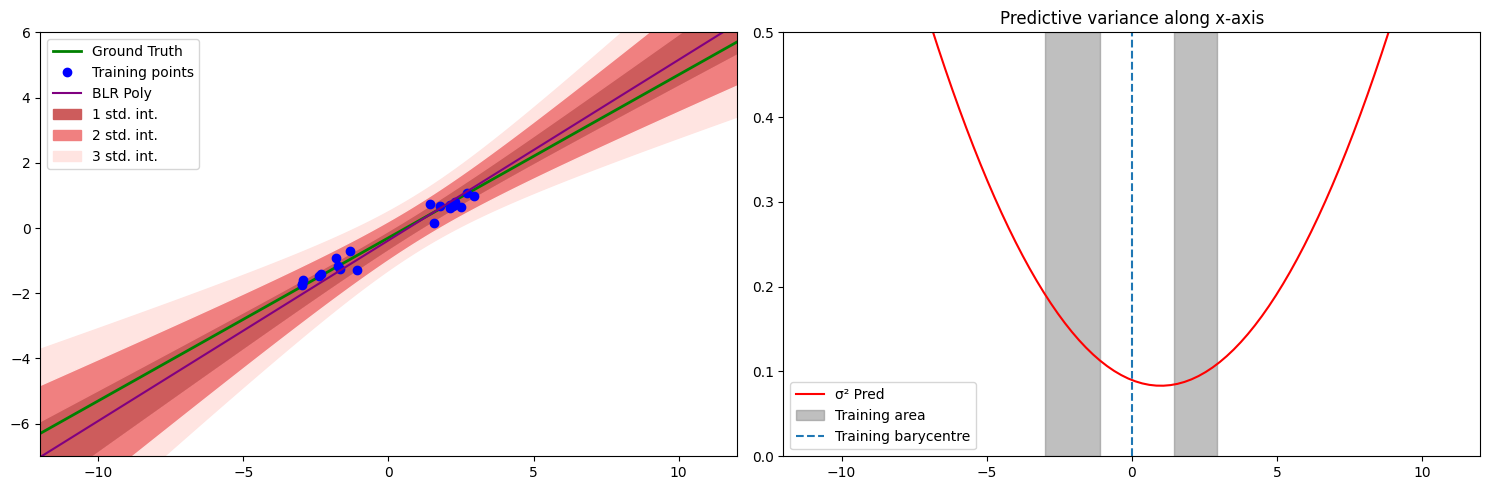

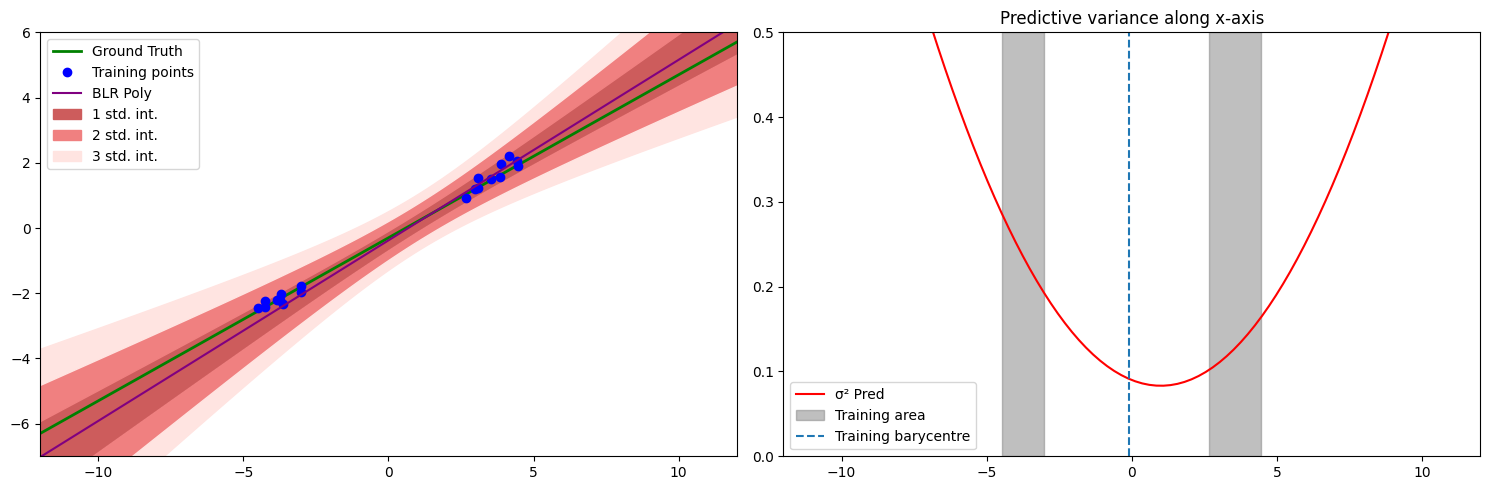

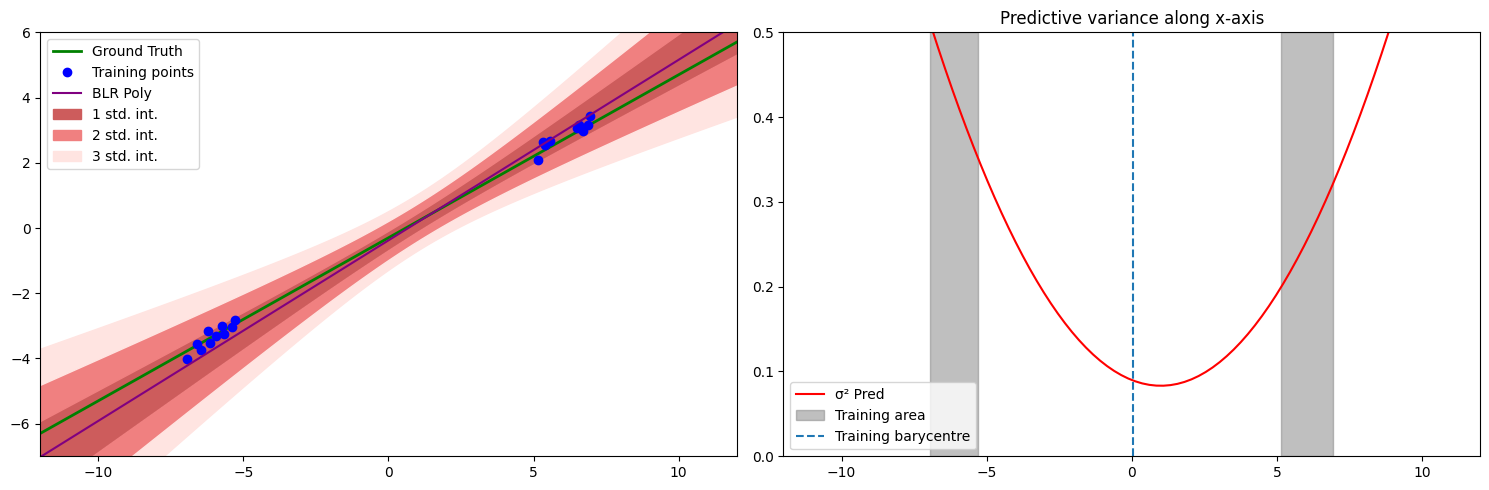

In [17]:
# Define a range of distances between the clusters
distances = [0.5, 1, 2, 5, 10]

# Iterate over each specified distance
for distance in distances:
    # Generate the left cluster by uniformly sampling points from a specified range
    left_cluster = np.random.uniform(-distance/2 - 2, -distance/2, 10)
    # Generate the right cluster in a similar fashion, symmetrically positioned around 0
    right_cluster = np.random.uniform(distance/2, distance/2 + 2, 10)
    
    # Concatenate the two clusters to form the training set
    dataset_hole['X_train'] = np.concatenate((left_cluster, right_cluster), axis=0)
    # Generate the corresponding training labels with some noise
    dataset_hole['y_train'] = f_linear(dataset_hole['X_train'], noise_amount=1, sigma=sigma)

    # Use the predictive function to generate predictions for the test set
    predictions = [f_pred(x) for x in dataset_hole['X_test']]

    # Unzip the predictions to separate means and standard deviations
    means, stds = zip(*predictions)

    # Plot the results using the custom plot function
    plot_results(dataset_hole['X_train'], dataset_hole['y_train'], 
                 dataset_hole['X_test'], dataset_hole['y_test'], 
                 np.array(means), np.array(stds), 
                 xmin=-12, xmax=12, ymin=-7, ymax=6, 
                 stdmin=0.0, stdmax=0.5, 
                 save=True, 
                 save_path=figpath + f'hole/results_hole_distance_{distance}.pdf')
    # Display the plot
    plt.show()


**<font color='red'>CHECK REPORT FOR ANSWERS</font>**

## Part II: Non Linear models

We now introduce a more complex toy dataset, which is an increasing sinusoidal curve. The goal of this part is to get insight on the importance of the chosen basis function on the predictive variance behavior.

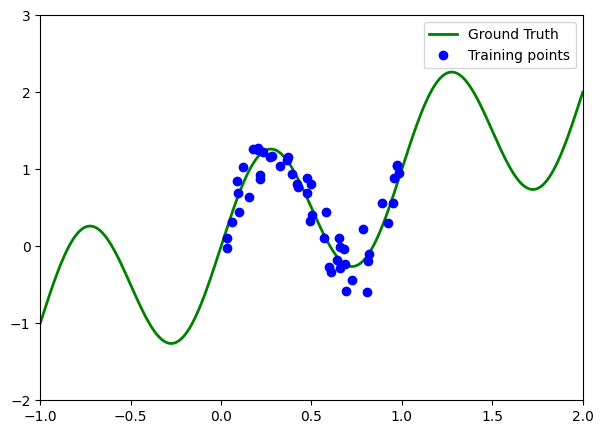

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate sinusoidal values with optional noise
def f_sinus(x, noise_amount, sigma=0.2):
    """
    Generate sinusoidal target data with noise.

    Args:
      x: (array) input values.
      noise_amount: (float) scaling factor for noise.
      sigma: (float) standard deviation of noise.

    Returns:
      (array) sinusoidal values with added noise.
    """
    # Calculate the sinusoidal values
    y = np.sin(2 * np.pi * x) + x
    # Add Gaussian noise to the sinusoidal values
    noise = np.random.normal(0, sigma, len(x))
    return y + noise_amount * noise

# Set the noise level for the dataset
sigma = 0.2
# Define the number of points in the dataset
nbpts = 50

# Initialize the dataset dictionary
dataset_sinus = {}
# Create uniformly distributed training points within the interval [0, 1]
dataset_sinus['X_train'] = np.random.uniform(0, 1, nbpts)
# Generate training labels with noise
dataset_sinus['y_train'] = f_sinus(dataset_sinus['X_train'], noise_amount=1, sigma=sigma)

# Generate test points for a denser interval [-1, 2]
dataset_sinus['X_test'] = np.linspace(-1, 2, 10 * nbpts)
# Generate test labels without noise
dataset_sinus['y_test'] = f_sinus(dataset_sinus['X_test'], noise_amount=0, sigma=sigma)

# Set hyperparameters for the Bayesian model
dataset_sinus['ALPHA'] = 0.05  # Precision of the prior
dataset_sinus['BETA'] = 1 / (2.0 * sigma ** 2)  # Precision of the noise

# Plot the dataset
plt.figure(figsize=(7, 5))
plt.xlim(xmin=-1, xmax=2)
plt.ylim(ymin=-2, ymax=3)
# Plot the ground truth as a green line
plt.plot(dataset_sinus['X_test'], dataset_sinus['y_test'], color='green', linewidth=2,
         label="Ground Truth")
# Plot the training points as blue dots
plt.plot(dataset_sinus['X_train'], dataset_sinus['y_train'], 'o', color='blue', label='Training points')
plt.legend()
# Save the plot to a file
plt.savefig(figpath + 'nonlinear_data.pdf')
# Display the plot
plt.show()


### II.1 Polynomial basis functions

We will first use polynomial basis functions:
$$\phi:x \rightarrow (\phi_0,\phi_1,...,\phi_{D-1})$$
where $\phi_j = x^j$ for $j \geq 0$ and $D \geq 0$


Design matrix $\Phi$ defined on training set is:
$$ \Phi=
  \begin{bmatrix}
    1 & x_1 & x_1^2 &... &x_1^{D-1} \\
    ... & ... & ... & ...\\
    1 & x_n & x_n^2 &... &x_n^{D-1}
  \end{bmatrix}
$$

**Question 2.1: Code polynomial basis function**

In [19]:
def phi_polynomial(x, degree=10):
    """ Polynomial Basis Functions
    
    Args:
      x: (float) 1D input
      degree: (int) the degree of the polynomial
      
    Returns:
      (array) polynomial features of x
    """
    # Compute the polynomial terms x^0, x^1, ..., x^degree
    return np.array([x**i for i in range(degree + 1)])


**Question 2.2 : Code and visualize results on sinusoidal dataset using polynomial basis functions. What can you say about the predictive variance?**

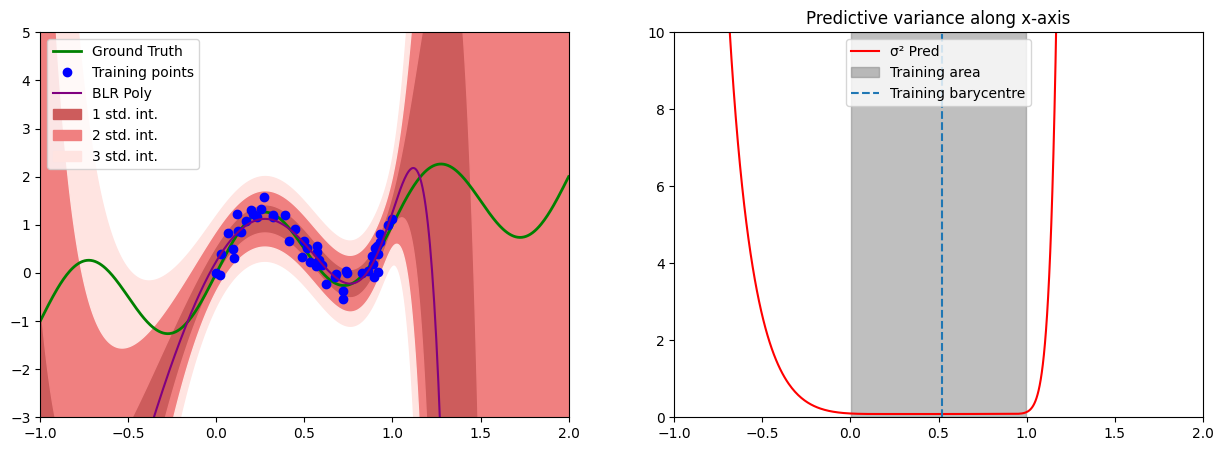

In [47]:
# Use the previously defined closed_form function
f_pred_poly = closed_form(phi_polynomial, dataset_sinus['X_train'], dataset_sinus['y_train'], 
                          dataset_sinus['ALPHA'], dataset_sinus['BETA'], degree=10)

# Predict on test points
predictions_poly = [f_pred_poly(x) for x in dataset_sinus['X_test']]

# Extract means and standard deviations
means_poly, stds_poly = zip(*predictions_poly)

# Plotting the results
plot_results(dataset_sinus['X_train'], dataset_sinus['y_train'], 
             dataset_sinus['X_test'], dataset_sinus['y_test'], 
             np.array(means_poly), np.array(stds_poly), 
             xmin=-1, xmax=2, ymin=-3, ymax=5, stdmin=0, stdmax=10)




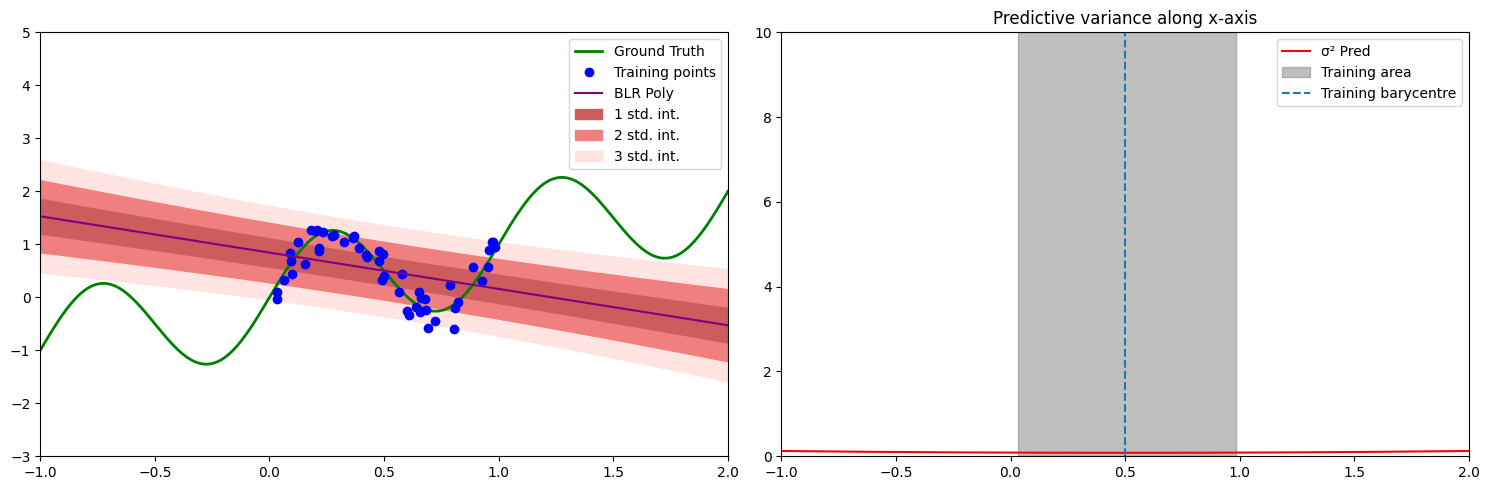

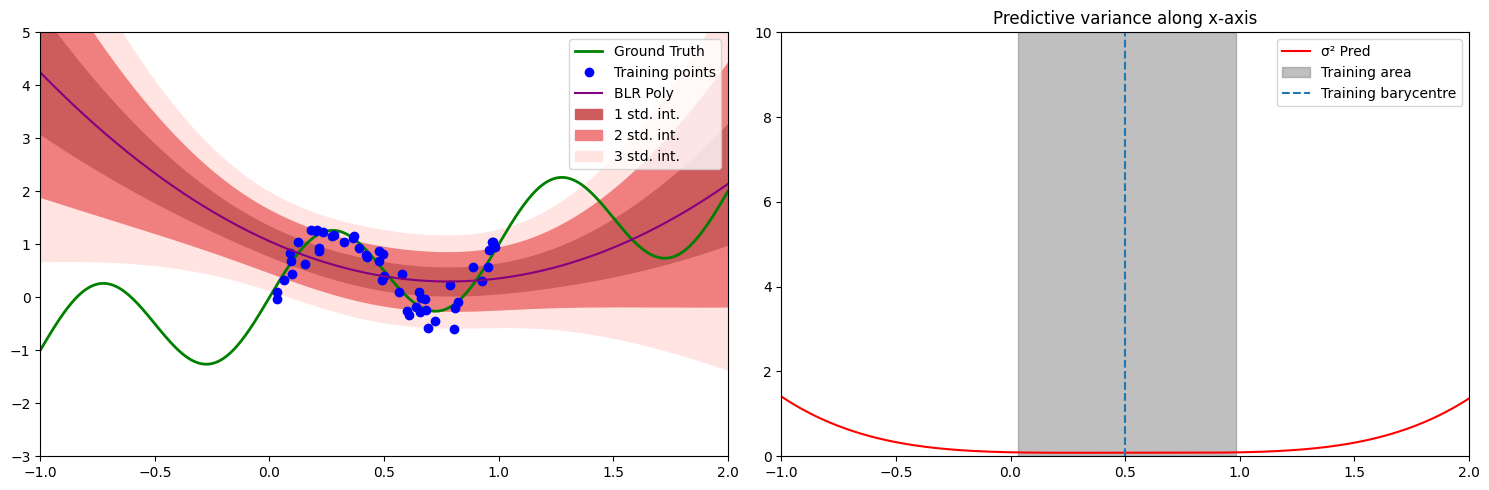

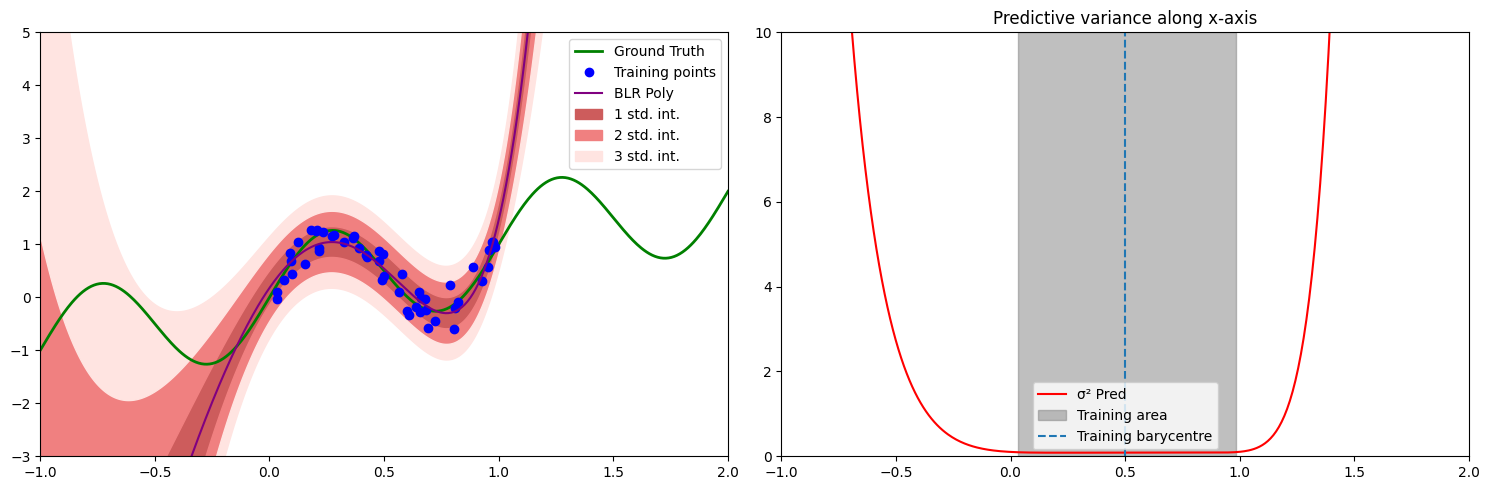

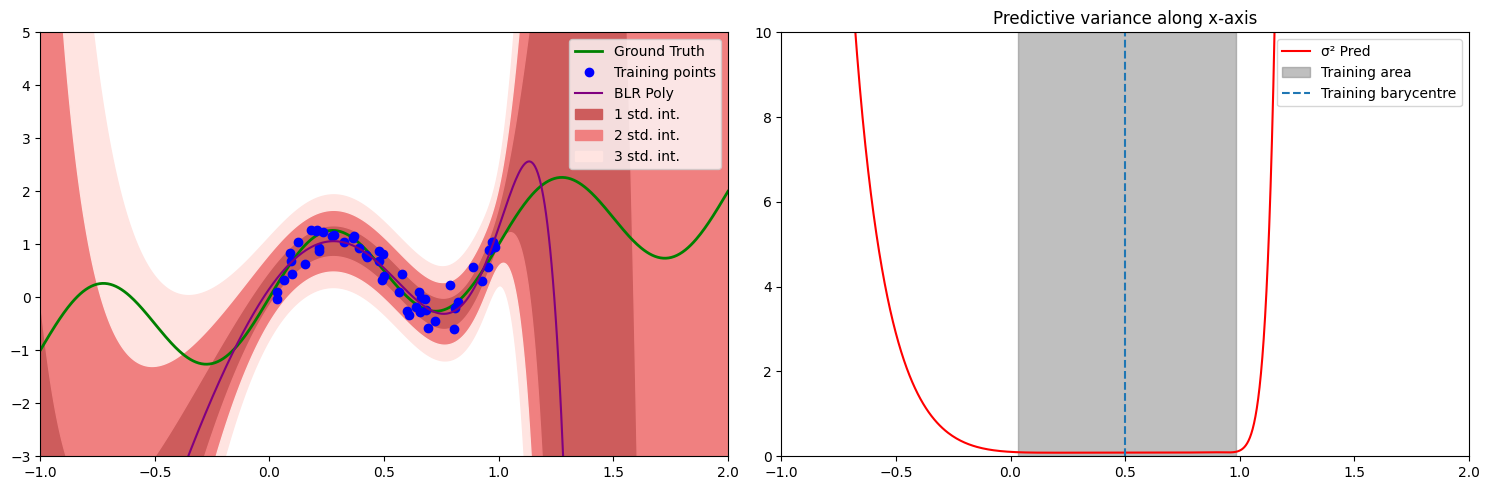

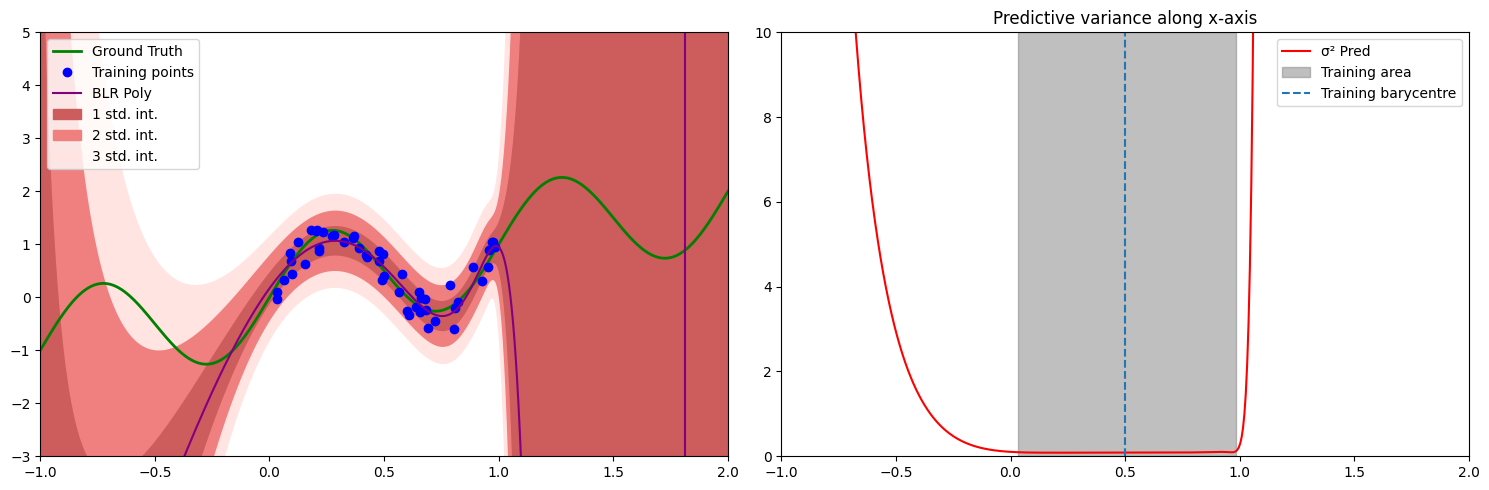

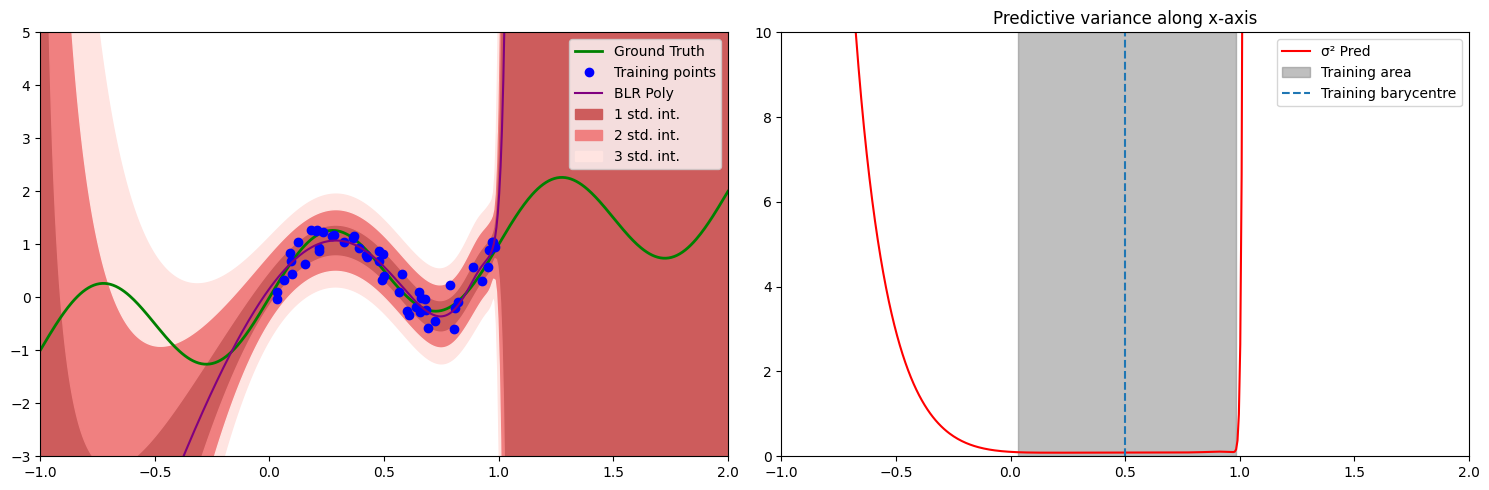

In [20]:
# List of polynomial degrees to evaluate
degrees = [1, 2, 5, 10, 20, 50]

# Iterate over the list of degrees
for degree in degrees:
    # Create the polynomial prediction function for the current degree using the closed form solution
    f_pred_poly = closed_form(phi_polynomial, dataset_sinus['X_train'], dataset_sinus['y_train'], 
                              dataset_sinus['ALPHA'], dataset_sinus['BETA'], degree=degree)

    # Generate predictions for the test set
    predictions_poly = [f_pred_poly(x) for x in dataset_sinus['X_test']]

    # Unpack the predictions into means and standard deviations
    means_poly, stds_poly = zip(*predictions_poly)

    # Define the title for the plot based on the current degree
    title = f"polynomial_deg_{str(degree)}.pdf"
    
    # Plot the results with the specified parameters and save to the designated path
    plot_results(dataset_sinus['X_train'], dataset_sinus['y_train'], 
                 dataset_sinus['X_test'], dataset_sinus['y_test'], 
                 np.array(means_poly), np.array(stds_poly), 
                 xmin=-1, xmax=2, ymin=-3, ymax=5, stdmin=0, stdmax=10, save=True, save_path=figpath + title)


**<font color='red'>CHECK REPORT FOR ANSWERS</font>**

### II.2 Gaussian basis functions

Now, let's consider gaussian basis functions:
$$\phi:x \rightarrow (\phi_0,\phi_1,...,\phi_M)$$
where $\phi_j = \exp \Big ( -\frac{(x-\mu_j)^2}{2s^2} \Big )$ for $j \geq 0$


Design matrix $\Phi$ defined on training set is:
$$ \Phi=
  \begin{bmatrix}
    \phi_0(x_1) & \phi_1(x_1) &... &\phi_M(x_1) \\
    ... & ... & ... & ...\\
    \phi_0(x_n) & \phi_1(x_n) &... &\phi_M(x_n)
  \end{bmatrix}
$$

**Question 2.3: Code gaussian basis function**

In [22]:
# Constants for Gaussian basis functions
MU_MIN = 0
MU_MAX = 1
M = 9

def phi_gaussian(x, MU_MIN=MU_MIN, MU_MAX=MU_MAX, M=M, s=None):
    """
    Calculate Gaussian basis features for input x.

    Args:
      x: (float) 1D input.
      MU_MIN: (float) Minimum mean for the Gaussian functions.
      MU_MAX: (float) Maximum mean for the Gaussian functions.
      M: (int) Number of Gaussian functions.
      s: (float) Standard deviation for the Gaussian functions. If None, calculated as spread.

    Returns:
      (np.array) Array of Gaussian features for x.
    """
    # Define the means of the Gaussian functions
    mus = np.linspace(MU_MIN, MU_MAX, M)
    # If s is not provided, calculate it as the spread of the means
    s = s if s is not None else (MU_MAX - MU_MIN) / M
    # Calculate the Gaussian features for x
    return np.exp(-(x - mus) ** 2 / (2 * s ** 2))

**Question 2.4 : Code and visualize results on sinusoidal dataset using Gaussian basis functions. What can you say this time about the predictive variance?**

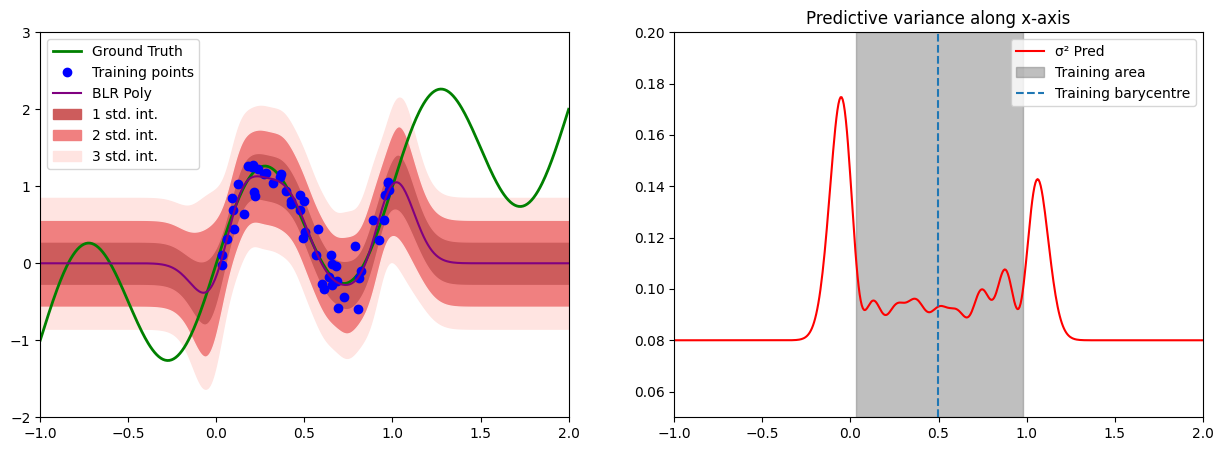

In [23]:
# Use the closed_form function with the Gaussian basis function
f_pred_gaussian = closed_form(phi_gaussian, dataset_sinus['X_train'], dataset_sinus['y_train'], 
                              dataset_sinus['ALPHA'], dataset_sinus['BETA'])

# Predict on test points
predictions_gaussian = [f_pred_gaussian(x) for x in dataset_sinus['X_test']]

# Extract means and standard deviations
means_gaussian, stds_gaussian = zip(*predictions_gaussian)

# Now we would call plot_results function with these values and the specified parameters
plot_results(dataset_sinus['X_train'], dataset_sinus['y_train'], 
             dataset_sinus['X_test'], dataset_sinus['y_test'], 
             np.array(means_gaussian), np.array(stds_gaussian), 
             xmin=-1, xmax=2, ymin=-2, ymax=3, stdmin=0.05, stdmax=0.2)


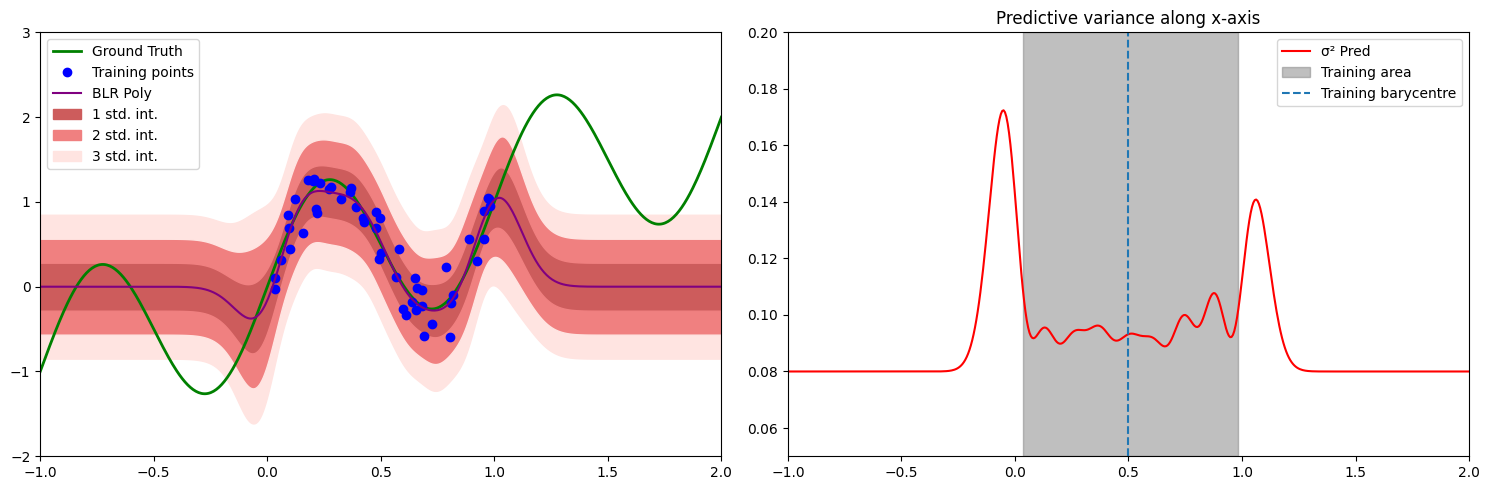

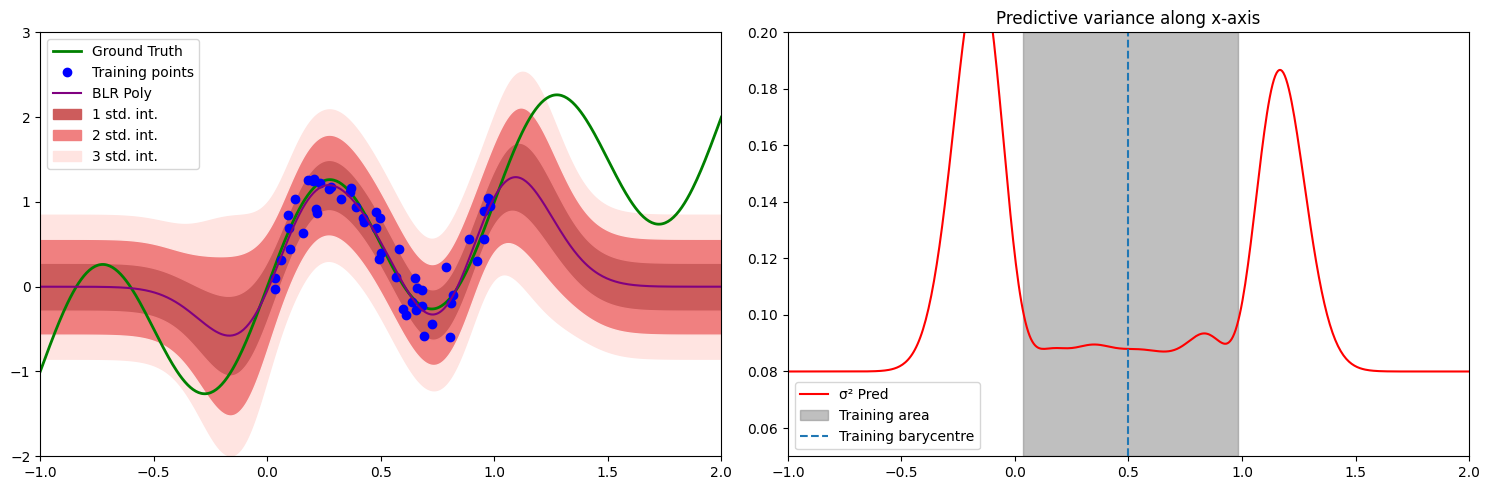

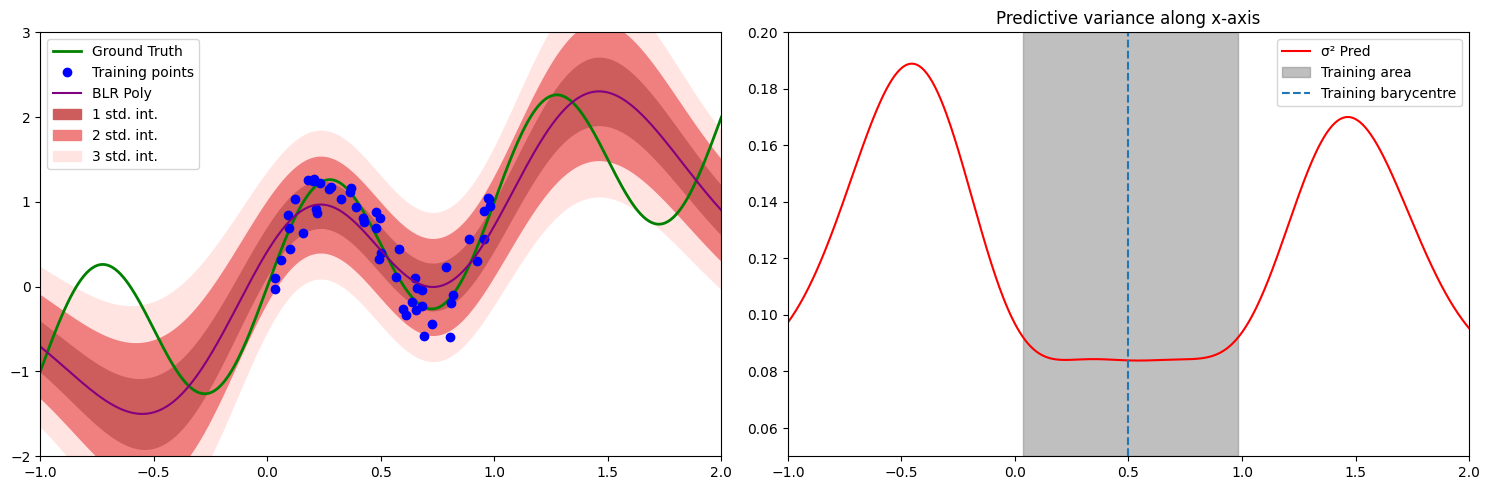

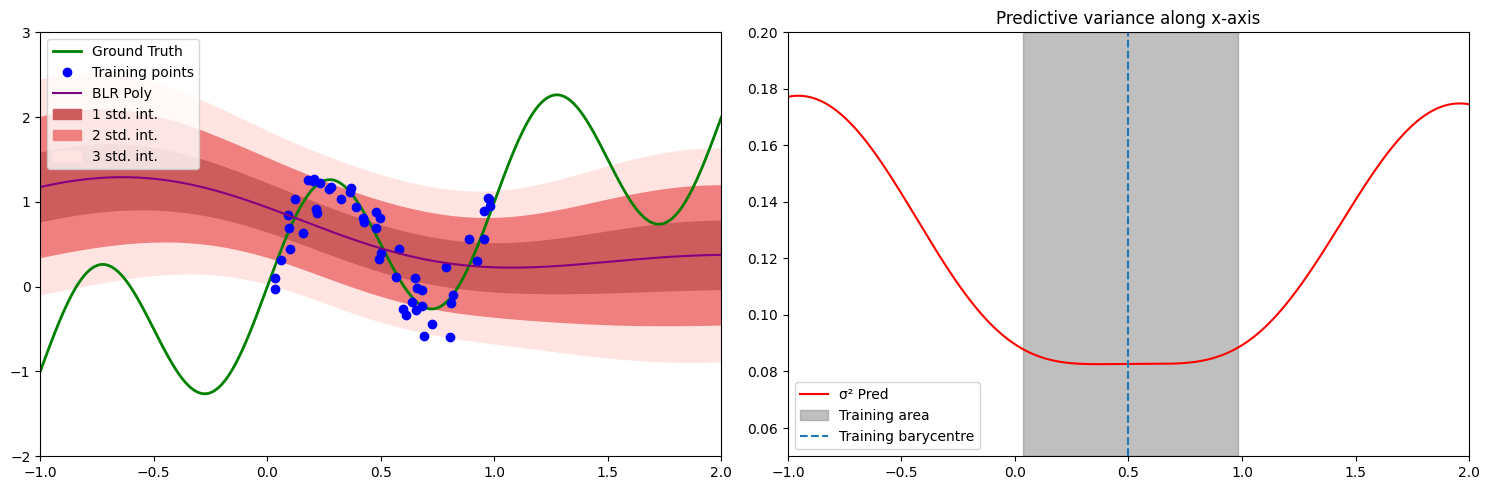

In [24]:
# List of standard deviations to iterate over for Gaussian basis functions
spacings = [0.11, 0.2, 0.5, 1.0]

# Iterate over different values of standard deviation
for spacing in spacings:
    # Create a new Gaussian basis function with the current standard deviation
    def phi_gaussian_spacing(x, MU_MIN=MU_MIN, MU_MAX=MU_MAX, M=M, s=spacing):
        return phi_gaussian(x, MU_MIN=MU_MIN, MU_MAX=MU_MAX, M=M, s=s)

    # Use the closed_form function with the Gaussian basis function to get the predictive model
    f_pred_gaussian = closed_form(phi_gaussian_spacing, dataset_sinus['X_train'], dataset_sinus['y_train'], 
                                  dataset_sinus['ALPHA'], dataset_sinus['BETA'])

    # Generate predictions for the test points
    predictions_gaussian = [f_pred_gaussian(x) for x in dataset_sinus['X_test']]

    # Extract the mean and standard deviation from the predictions
    means_gaussian, stds_gaussian = zip(*predictions_gaussian)
    
    # Plot the results using the custom plot function and save the figures
    plot_results(dataset_sinus['X_train'], dataset_sinus['y_train'],
                 dataset_sinus['X_test'], dataset_sinus['y_test'],
                 np.array(means_gaussian), np.array(stds_gaussian),
                 xmin=-1, xmax=2, ymin=-2, ymax=3, stdmin=0.05, stdmax=0.2,
                 save=True, save_path=figpath + f"gaussian/results_gaussian_{spacing}.pdf")

**<font color='red'>CHECK REPORT FOR ANSWERS</font>**

**Question 2.5: Explain why in regions far from training distribution, the predictive variance converges to this value when using localized basis functions such as Gaussians.**

**<font color='red'>CHECK REPORT FOR ANSWERS</font>**